# Computing the distance to collision

In this tutorial, you learn how to use the Python API to compute the around a static agent and the distance it may travel in different directions before colliding. You can use these functionality to develop your own navigation behavior.

In [1]:
from navground import core
from matplotlib import pyplot as plt
from matplotlib import patches
import numpy as np

Let's start by instantiating a [CollisionComputation](..reference/core/python/collision_computation.html#navground.core.CollisionComputation) object

In [2]:
cc = core.CollisionComputation()

which can be setup up with the same fields as a [GeometricState](..reference/core/python/state.html#geometric): line segments, and static/dynamic discs.

## Static distance to collision

We add two wall to setup a corridor and randomly draw some static obstacles

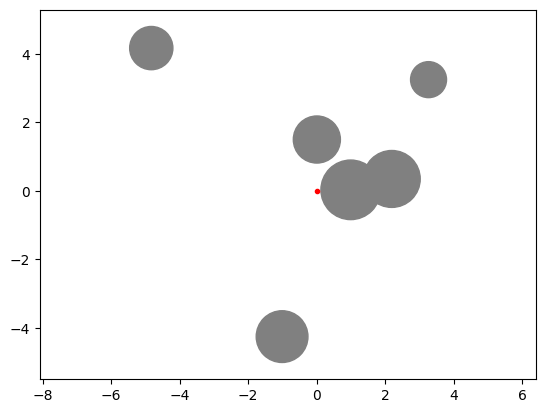

In [3]:
import random

def r_disc():
    return core.Disc(
        (random.random() * 10 - 5, random.random() * 10 - 5), 
        random.random() * 0.5 + 0.5)

obstacles = [r_disc() for _ in range(6)]
line_segments=[
    core.LineSegment(p1=(-5.0, 5.0), p2=(5.0, 5.0)),
    core.LineSegment(p1=(-5.0, -2.0), p2=(5.0, -2.0))]


cc.setup(line_segments=line_segments, static_discs=obstacles)

fig, ax = plt.subplots()

for o in obstacles:
    circle = patches.Circle(o.position, o.radius, color='gray')
    ax.add_patch(circle)
    
ax.plot(0, 0, '.r')
    
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.axis('equal');

We can then compute the free distance in any direction from the red dot. E.g. forwards

In [4]:
horizon = 7.0
cc.static_free_distance(angle=0.0, max_distance=horizon)

0.12754799360056712

or left

In [5]:
cc.static_free_distance(angle=np.pi/2, max_distance=horizon)

0.8101982338634741

or compute distances for all angles in a circular sector

In [6]:
angles = cc.get_angles_for_sector(-np.pi/2, length=np.pi, resolution=51)

In [7]:
distances = np.asarray(cc.get_free_distance_for_sector(
    -np.pi/2, length=np.pi, resolution=51, max_distance=horizon, dynamic=False)).T

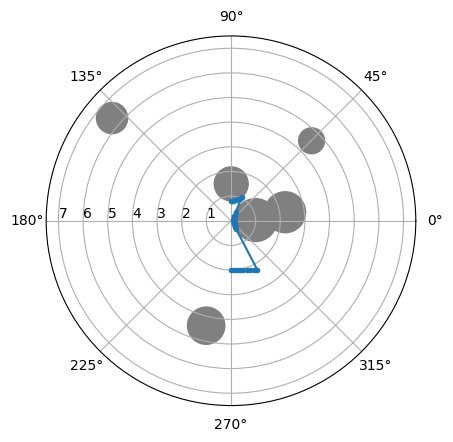

In [8]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(angles, distances, '.-')
ax.set_rmax(horizon + 0.5)
ax.set_rlabel_position(180)
ax.grid(True)
for o in obstacles:
    circle = patches.Circle(o.position, o.radius, color='gray', transform=ax.transData._b)
    ax.add_patch(circle)

## Dynamic distance to collision

Similarly, we can compute the free distance until a possible collision if the agent would move at a certain speed.

As expected, when all obstacles are static, this results in the same values as before

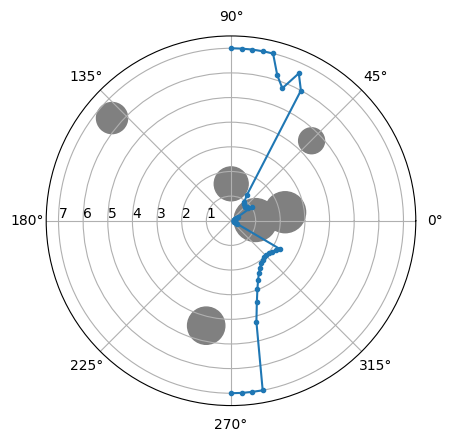

In [9]:
dynamic_distances = np.asarray(cc.get_free_distance_for_sector(
    -np.pi, length=2 * np.pi, resolution=51, max_distance=horizon, dynamic=True, speed=1.0)).T

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(angles, dynamic_distances, '.-')
ax.set_rmax(horizon + 0.5)
ax.set_rlabel_position(180)
ax.grid(True)
for o in obstacles:
    circle = patches.Circle(o.position, o.radius, color='gray', transform=ax.transData._b)
    ax.add_patch(circle)

This changes when some obstacles are dynamic, like when we add a neighbor following close behind

In [10]:
neighbors = [core.Neighbor(position=(-3, -0.25), radius=1.0, velocity=(1.1, 0.0))]

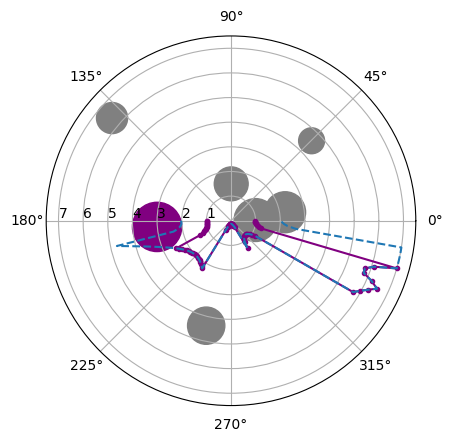

In [11]:
cc.setup(line_segments=line_segments, static_discs=obstacles, dynamic_discs=neighbors)

angles = cc.get_angles_for_sector(-np.pi, length=np.pi, resolution=101)

dynamic_distances = np.asarray(cc.get_free_distance_for_sector(
    -np.pi, length=2 * np.pi, resolution=101, max_distance=horizon, dynamic=True, speed=1.0)).T

static_distances = np.asarray(cc.get_free_distance_for_sector(
    -np.pi, length=2 * np.pi, resolution=101, max_distance=horizon, dynamic=False)).T

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(angles, dynamic_distances, '.-', color='purple')
ax.plot(angles, static_distances, '--')
ax.set_rmax(horizon + 0.5)
ax.set_rlabel_position(180)
ax.grid(True)
for o in obstacles:
    circle = patches.Circle(o.position, o.radius, color='gray', transform=ax.transData._b)
    ax.add_patch(circle)
for o in neighbors:
    circle = patches.Circle(o.position, o.radius, color='purple', transform=ax.transData._b)
    ax.add_patch(circle)  
    

## Pose

Try moving the pose of the agent and see how the static/dynamic distances changes

In [12]:
position = [0, 0]

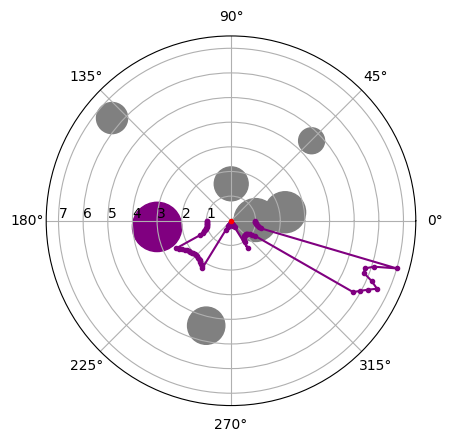

interactive(children=(FloatSlider(value=0.0, description='x', max=5.0, min=-5.0, step=0.01), FloatSlider(value…

In [13]:
from IPython.display import display
import ipywidgets as widgets

# x_range = widgets.FloatSlider(position[0], min=-5, max=5)
# y_range = widgets.FloatSlider(position[1],min=-5, max=5)

# display(x_range, y_range)

cc.setup(pose=core.Pose2(position, 0.0), line_segments=line_segments, static_discs=obstacles, dynamic_discs=neighbors)

dynamic_distances = np.asarray(cc.get_free_distance_for_sector(
    -np.pi, length=2 * np.pi, resolution=101, max_distance=horizon, dynamic=True, speed=1.0)).T

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
plot, *_ = ax.plot(angles, dynamic_distances, '.-', color='purple')
p_plot = ax.plot(*position, 'r.', transform=ax.transData._b)
ax.set_rmax(horizon + 0.5)
ax.set_rlabel_position(180)
ax.grid(True)
for o in obstacles:
    circle = patches.Circle(o.position, o.radius, color='gray', transform=ax.transData._b)
    ax.add_patch(circle)
for o in neighbors:
    circle = patches.Circle(o.position, o.radius, color='purple', transform=ax.transData._b)
    ax.add_patch(circle)  


@widgets.interact(x=(-5, 5, 0.01), y=(-5, 5, 0.01))
def update(x, y):
    cc.setup(pose=core.Pose2((x, y), 0.0), 
             line_segments=line_segments, 
             static_discs=obstacles, dynamic_discs=neighbors)
    dynamic_distances = np.array(cc.get_free_distance_for_sector(
        -np.pi, length=2 * np.pi, resolution=101, max_distance=horizon, dynamic=True, speed=1.0)).T
    plot.set_ydata(dynamic_distances)
    fig.canvas.draw()

# x_range.observe(on_change(0), names='value')
# y_range.observe(on_change(1), names='value')

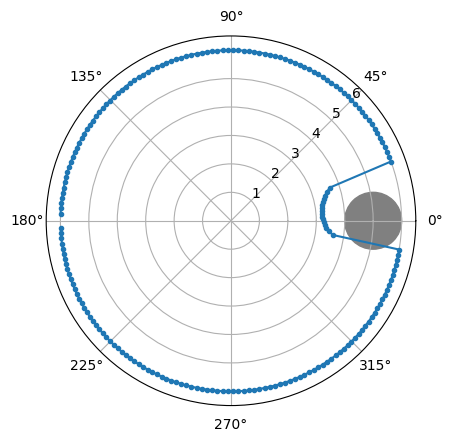

In [14]:
cc = core.CachedCollisionComputation()
horizon = 6.0
cc.resolution = 11
cc.min_angle = -3.1
cc.length = 6.2
neighbors = [core.Neighbor((5.0, 0.0), 1.0, (-0.5, 0.2))]
cc.setup(dynamic_discs=neighbors)
xs = np.asarray(cc.get_angles_for_sector(-3.1, 6.2, 201))
ys = np.asarray(cc.get_free_distance_for_sector(-3.1, 6.2, 201, 6.0, True, 2.0))
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(xs, ys, '.-')
ax.set_rmax(horizon + 0.5)
ax.set_rlabel_position(45)

for o in neighbors:
    circle = patches.Circle(o.position, o.radius, color='gray', transform=ax.transData._b)
    ax.add_patch(circle)

ax.grid(True)

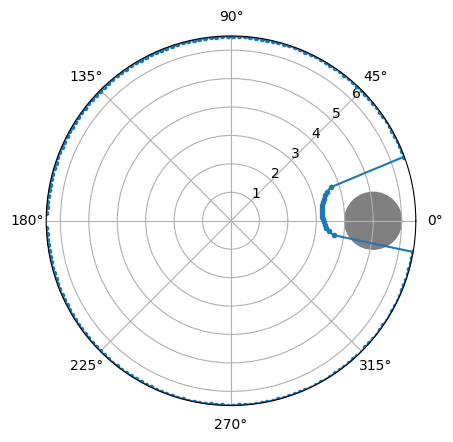

In [15]:
cc.resolution = 202
cc.min_angle = -np.pi
cc.length = 2 * np.pi
cc.speed = 2.0
cc.max_distance = 6.5
neighbors = [core.Neighbor((5.0, 0.0), 1.0, (-0.5, 0.2))]
cc.setup(dynamic_discs=neighbors)
ys = np.asarray(cc.get_free_distance(True))
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(xs, ys, '.-')
ax.set_rmax(horizon + 0.5)
ax.set_rlabel_position(45)

for o in neighbors:
    circle = patches.Circle(o.position, o.radius, color='gray', transform=ax.transData._b)
    ax.add_patch(circle)

ax.grid(True)

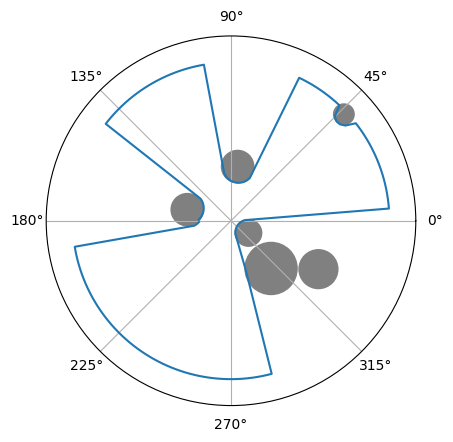

In [16]:
import random

def r_disc(static=True):
    return core.Neighbor(
        (random.random() * 10 - 5, random.random() * 10 - 5), 
        random.random() * 0.9 + 0.1, ((0.0, 0.0) if static else (random.random(), random.random())))

cc.resolution = 202
cc.min_angle = -np.pi
cc.length = 2 * np.pi
cc.speed = 2.0
cc.max_distance = 6
neighbors = [r_disc(static=True) for _ in range(6)]
cc.setup(dynamic_discs=neighbors)
ys = np.array(cc.get_free_distance(True))
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(xs, ys, '-')
ax.set_rmax(7)
ax.set_rticks([])
for o in neighbors:
    circle = patches.Circle(o.position, o.radius, color='gray', transform=ax.transData._b)
    ax.add_patch(circle)

ax.grid(True)

In [17]:
%%timeit
cc = core.CachedCollisionComputation()
cc.resolution = 31
cc.min_angle = -3.1
cc.length = 6.2
cc.speed = 2.0
cc.max_distance = 6.5
neighbors = [core.Neighbor((5.0, 0.0), 1.0, (-0.5, 0.2))]
cc.setup(dynamic_discs=neighbors)
cc.get_free_distance(True)

4.11 μs ± 22.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [18]:
cc = core.CachedCollisionComputation()
cc.resolution = 31
cc.min_angle = -3.1
cc.length = 6.2
cc.speed = 2.0
cc.max_distance = 6.5
neighbors = [core.Neighbor((5.0, 0.0), 1.0, (-0.5, 0.2))]
cc.setup(dynamic_discs=neighbors)

In [19]:
%%timeit
cc.get_free_distance(True)

401 ns ± 3.02 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


For the folliwing, you need to install ipympl

```
pip install ipympl
```

In [20]:
%matplotlib widget

In [22]:
# # set up plot
# fig, ax = plt.subplots(figsize=(6, 4))
# ax.set_ylim([-4, 4])
# ax.grid(True)
 
# # generate x values
# x = np.linspace(0, 2 * np.pi, 100)

# def my_sine(x, w, amp, phi):
#     """
#     Return a sine for x with angular frequeny w and amplitude amp.
#     """
#     return amp*np.sin(w * (x-phi))
 
# @widgets.interact(w=(0, 10, 1), amp=(0, 4, .1), phi=(0, 2*np.pi+0.01, 0.01))
# def update(w = 1.0, amp=1, phi=0):
#     """Remove old lines from plot and plot new one"""
#     [l.remove() for l in ax.lines]
#     ax.plot(x, my_sine(x, w, amp, phi), color='C0')